In [1]:
import os
import re
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import tempfile
import shutil

In [2]:
data_dir = "GSE288199_raw"
sample_dirs = [d for d in os.listdir(data_dir)
               if os.path.isdir(os.path.join(data_dir, d))]

In [3]:
def read_10x_custom(sample_dir, var_names='gene_symbols'):
    """
    Use sc.read_10x_mtx() on a folder that has nonstandard 10x filenames by
    copying them into a temporary folder (with the standard 10x names).
    """
    
    # Find the files in sample_dir that end with _matrix.mtx.gz, etc.
    filenames = os.listdir(sample_dir)
    mtx_file  = [f for f in filenames if f.endswith("_matrix.mtx.gz")]
    bc_file   = [f for f in filenames if f.endswith("_barcodes.tsv.gz")]
    feat_file = [f for f in filenames if f.endswith("_features.tsv.gz")]

    if not (mtx_file and bc_file and feat_file):
        raise FileNotFoundError(
            f"Could not find matrix/barcodes/features in {sample_dir} with the suffixes:"
            " _matrix.mtx.gz, _barcodes.tsv.gz, _features.tsv.gz"
        )

    mtx_path  = os.path.join(sample_dir, mtx_file[0])
    bc_path   = os.path.join(sample_dir, bc_file[0])
    feat_path = os.path.join(sample_dir, feat_file[0])

    # Create a temp folder
    tmpdir = tempfile.mkdtemp(prefix="10x_temp_")
    try:
        # Copy the three files with standard 10x names
        shutil.copy(mtx_path,  os.path.join(tmpdir, "matrix.mtx.gz"))
        shutil.copy(bc_path,   os.path.join(tmpdir, "barcodes.tsv.gz"))
        shutil.copy(feat_path, os.path.join(tmpdir, "features.tsv.gz"))

        # Now read_10x_mtx will see them as the standard 10x file names
        adata = sc.read_10x_mtx(
            tmpdir, 
            var_names=var_names, 
            make_unique=True
        )
    finally:
        # Clean up the temp directory
        shutil.rmtree(tmpdir)

    return adata

In [4]:
hvg_n         = 5000                           # #HVGs to keep
leiden_res    = 0.6                            # tweak for cluster granularity

#   marker lists (feel free to expand)
markers = {
    "CD4": ["CD4", "IL7R", "CCR7"],
    "CD8": ["CD8A", "CD8B", "GZMB", "NKG7"],
}

# ----------------------- read + per‑sample prep -------------------------
adatas = []
for s1 in sample_dirs:
    adata = read_10x_custom(f'GSE288199_raw/{s1}')

    # make cell barcodes globally unique (sample suffix)
    new_index = [bc.rsplit('-', 1)[0] + f"-{s1}" for bc in adata.obs.index]
    adata.obs.index = new_index

    # basic normalisation / log1p you already started
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    adata.obs["sample"] = s1
    adatas.append(adata)

# -------------------------- concatenate samples ---------------------------
adata_all = ad.concat(adatas, join="outer", label="sample", keys=sample_dirs)

# -------------------- feature selection & scaling -------------------------
sc.pp.highly_variable_genes(adata_all, n_top_genes=hvg_n, flavor="cell_ranger")
adata_all = adata_all[:, adata_all.var["highly_variable"]]  # subset to HVGs
sc.pp.scale(adata_all, max_value=10)

# ----------------------- dimensionality + clustering ----------------------
sc.tl.pca(adata_all, svd_solver="arpack")
sc.pp.neighbors(adata_all, n_pcs=40, metric="cosine")
sc.tl.leiden(adata_all, resolution=leiden_res, key_added="cluster")
sc.tl.umap(adata_all)                             # optional, for plotting

# -------------------- CD4 / CD8 scores & predictions ----------------------
# per‑cell scores
sc.tl.score_genes(adata_all, gene_list=markers["CD4"], score_name="CD4_score")
sc.tl.score_genes(adata_all, gene_list=markers["CD8"], score_name="CD8_score")

# coarse per‑cluster means
clust_means = (
    adata_all.obs[["cluster", "CD4_score", "CD8_score"]]
    .groupby("cluster")
    .mean()
)

# label clusters: whichever marker score is higher
clust_means["predicted_type"] = np.where(
    clust_means["CD4_score"] > clust_means["CD8_score"], "CD4", "CD8"
)


# map back to every cell
adata_all.obs["CD_type_by_cluster"] = (
    adata_all.obs["cluster"].map(clust_means["predicted_type"])
)

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/app/software/umap-learn/0.5.3-foss-2022b/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/app/software/umap-learn/0.5.3-foss-2022b/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


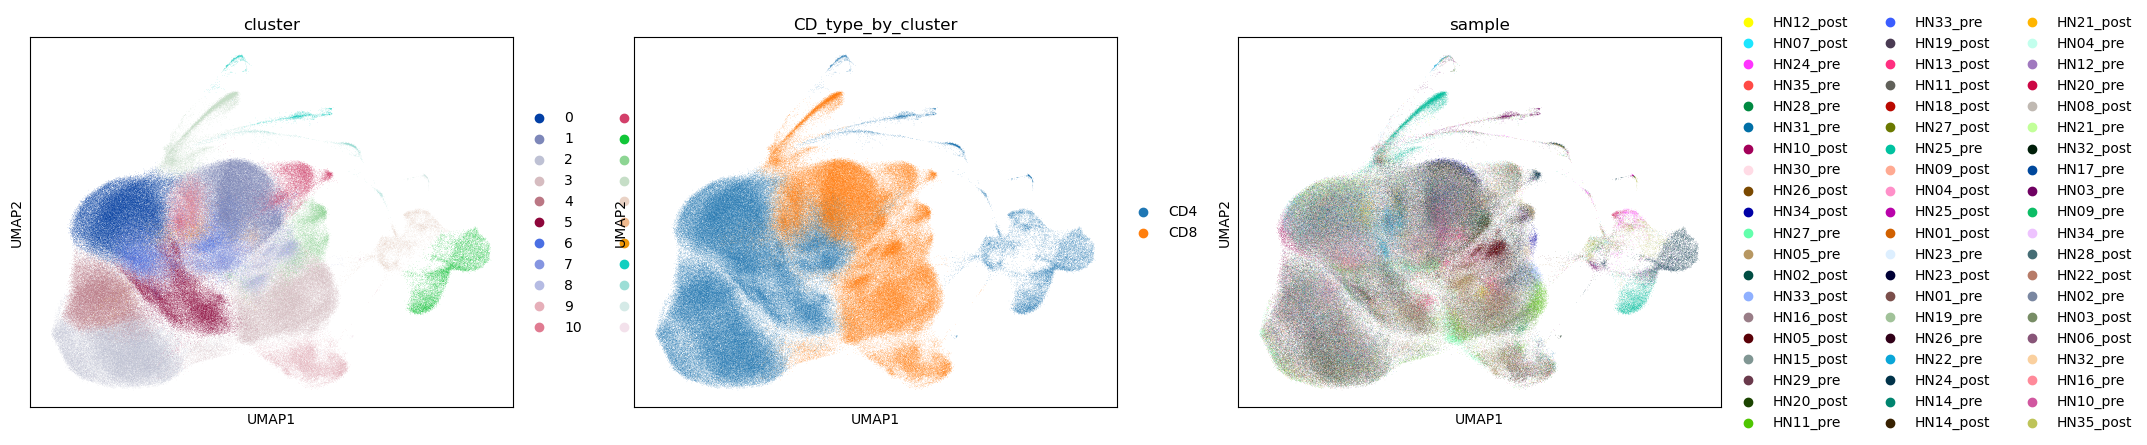

In [5]:
%matplotlib inline
sc.pl.umap(adata_all, color=["cluster", "CD_type_by_cluster", "sample"])


In [6]:
pd.crosstab(adata_all.obs['cluster'], adata_all.obs['CD_type_by_cluster'])

CD_type_by_cluster,CD4,CD8
cluster,,
0,58688,0
1,0,58426
2,53206,0
3,0,48297
4,36728,0
5,32680,0
6,23215,0
7,17322,0
8,0,13182


In [7]:
adata_all.obs

,sample,cluster,CD4_score,CD8_score,CD_type_by_cluster
AAACCTGAGATCCGAG-HN12_post,HN12_post,2,0.550533,-0.556298,CD4
AAACCTGAGGCTAGCA-HN12_post,HN12_post,4,-0.634026,-0.844752,CD4
AAACCTGCAGCATGAG-HN12_post,HN12_post,2,-0.616185,-0.796295,CD4
AAACCTGGTTCCACAA-HN12_post,HN12_post,2,-0.334483,-0.705763,CD4
AAACCTGTCAAAGTAG-HN12_post,HN12_post,3,-0.456430,0.534275,CD8
...,...,...,...,...,...
TTTGTCAAGGAGTCTG-HN35_post,HN35_post,15,-0.324029,-0.747458,CD4
TTTGTCACATCACCCT-HN35_post,HN35_post,5,0.375692,-0.441711,CD4
TTTGTCACATTTGCTT-HN35_post,HN35_post,12,-0.812439,-0.295729,CD4
TTTGTCAGTGTTTGTG-HN35_post,HN35_post,4,0.036984,-0.574737,CD4


In [8]:
obs_df = adata_all.obs.reset_index()
final_df = obs_df[['index', 'CD_type_by_cluster']].rename(columns={'index': 'cell_barcode', 'CD_type_by_cluster': 'cell_type'})
final_df

,cell_barcode,cell_type
0,AAACCTGAGATCCGAG-HN12_post,CD4
1,AAACCTGAGGCTAGCA-HN12_post,CD4
2,AAACCTGCAGCATGAG-HN12_post,CD4
3,AAACCTGGTTCCACAA-HN12_post,CD4
4,AAACCTGTCAAAGTAG-HN12_post,CD8
...,...,...
425765,TTTGTCAAGGAGTCTG-HN35_post,CD4
425766,TTTGTCACATCACCCT-HN35_post,CD4
425767,TTTGTCACATTTGCTT-HN35_post,CD4
425768,TTTGTCAGTGTTTGTG-HN35_post,CD4


In [9]:
final_df.to_csv('cell_type.csv',index = False)